In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.cluster import DBSCAN
from collections import defaultdict


Loading images

In [237]:
# Loading the images
# Get the current working directory
baseFolder = os.getcwd()

# Select the path that contains the photos

folder = os.path.join(baseFolder,"FINAL_PHOTOS","FOLDING_LINES")
# Load vertical left image
image_name_1 = "6_V_L.png" # #_h_up , #_h_D , #_V_L , #_V_R 
image_path_1 = os.path.join(folder, image_name_1)
image_ver_left = cv.imread(image_path_1, 0)
# Load vertical right image
image_name_2 = "6_V_R.png" # #_h_up , #_h_D , #_V_L , #_V_R 
image_path_2 = os.path.join(folder, image_name_2)
image_ver_right = cv.imread(image_path_2, 0)
# Load horizontal up image
image_name_3 = "6_h_up.png" # #_h_up , #_h_D , #_V_L , #_V_R
image_path_3 = os.path.join(folder, image_name_3)
image_hor_up = cv.imread(image_path_3, 0)
# Load horizontal down image
image_name_4 = "6_h_D.png" # #_h_up , #_h_D , #_V_L , #_V_R
image_path_4 = os.path.join(folder, image_name_4)
image_hor_down = cv.imread(image_path_4, 0)

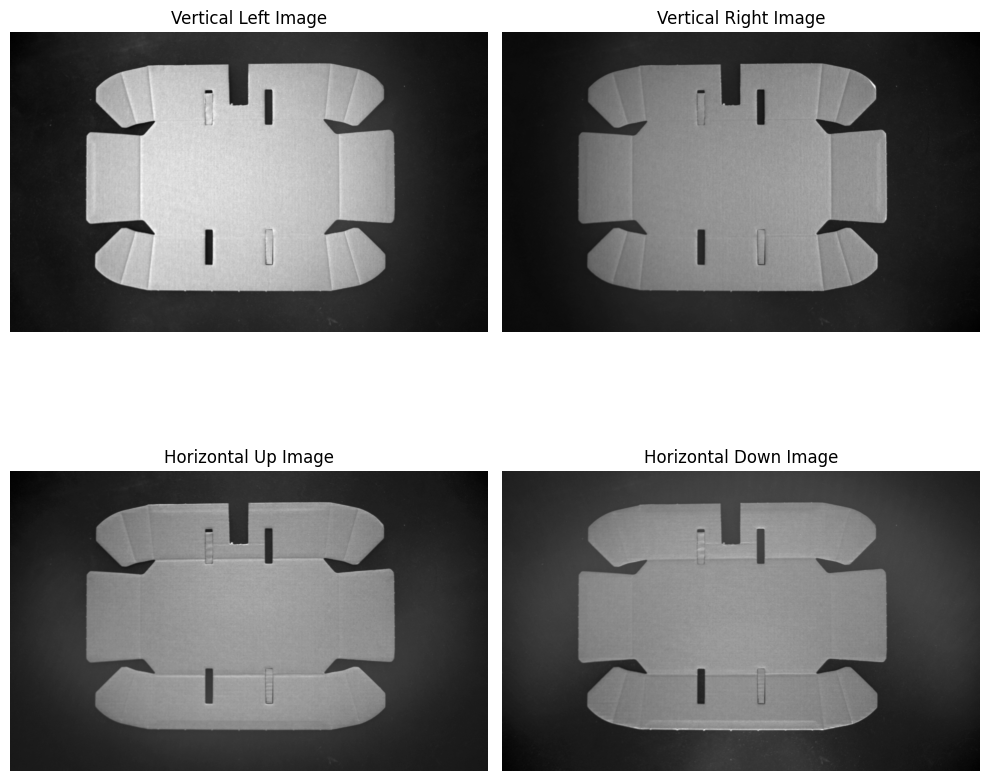

In [238]:
#Plot of the images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_ver_left, cmap='gray')
plt.title('Vertical Left Image')
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(image_ver_right, cmap='gray')
plt.title('Vertical Right Image')
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(image_hor_up, cmap='gray')
plt.title('Horizontal Up Image')
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(image_hor_down, cmap='gray')
plt.title('Horizontal Down Image')
plt.axis("off")
plt.tight_layout()
plt.show()

Calibration Parameters

In [239]:
# We load the camera calibration results (We took the photos with the first camera setup)
cameraParameters = np.load(baseFolder + "/calibration/camera_setup1.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']

Extra functions

In [240]:
def get_line_features(x1, y1, x2, y2):
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    return [center_x, center_y, angle]

def fuse_lines(line_group):
    points = [pt for line in line_group for pt in line]
    [vx, vy, x0, y0] = cv.fitLine(np.array(points), cv.DIST_L2, 0, 0.01, 0.01)
    vx, vy = vx[0], vy[0]
    x0, y0 = x0[0], y0[0]
    
    # Proyectar hacia los extremos del grupo
    lengths = [np.dot([x - x0, y - y0], [vx, vy]) for x, y in points]
    min_len, max_len = min(lengths), max(lengths)
    
    p1 = (int(x0 + vx * min_len), int(y0 + vy * min_len))
    p2 = (int(x0 + vx * max_len), int(y0 + vy * max_len))
    return p1, p2

def focus_area(image):
    # Thresholding the imnage OTSU gives us the optimal threshold value
    _ , th_Bin_OTSU = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Find the contours in the image
    contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We search the biggest contour Area Based
    contour_max = max(contours, key=cv.contourArea)

    # Bounding box of the biggest contour
    x, y, w, h = cv.boundingRect(contour_max)

    # We expand the ROI
    margin = 10  # Additional pixels to the ROI
    x_roi = max(x - margin, 0)
    y_roi = max(y - margin, 0)
    w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
    h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)  #With ROI coordinates we can select the desired part of the image
    # We use the ROI found in the previous step
    roi = th_Bin_OTSU[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

    # We apply the canny on the ROI
    canny_edges_roi = cv.Canny(roi, 40, 100, L2gradient=True)

    # We find the contours of the image
    contours, _ = cv.findContours(canny_edges_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # We only keep the contours with the maximum area
    max_contour = max(contours, key=cv.contourArea)
    # We calculate the convex hull of the maximum contour
    hull = cv.convexHull(max_contour)
    # We add the offset of the ROI to the convex hull
    hull_offset = hull + np.array([[[x_roi, y_roi]]])

    # Find the extreme points of the convex hull
    topmost    = tuple(hull_offset[hull_offset[:,:,1].argmin()][0])
    bottommost = tuple(hull_offset[hull_offset[:,:,1].argmax()][0])
    leftmost   = tuple(hull_offset[hull_offset[:,:,0].argmin()][0])
    rightmost  = tuple(hull_offset[hull_offset[:,:,0].argmax()][0])
    
    # Step 1: Calculate the bounding box of the convex hull
    x_min = leftmost[0]
    x_max = rightmost[0]
    y_min = topmost[1]
    y_max = bottommost[1]

    width = x_max - x_min
    height = y_max - y_min

    # Step 2: Divide the bounding box into four areas
    third_width = width // 3
    third_height = height // 3

    # --- Horizontal areas (top, bottom) ---
    area_top    = (x_min, y_min, width, third_height)
    area_bottom = (x_min, y_min + 2 * third_height, width, third_height)

    # --- Vertical areas (left, right) ---
    area_left   = (x_min, y_min, third_width, height)
    area_right  = (x_min + 2 * third_width, y_min, third_width, height)

    return (area_top, area_bottom, area_left, area_right)

def mask_image(image, size):
    # Recieves blurred image and returns a mask of the contour
    contour_mask = np.zeros_like(image, dtype=np.uint8)

    # Thresholding the imnage OTSU gives us the optimal threshold value
    _ , th_Bin_OTSU = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Find the contours in the image
    contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We search the biggest contour Area Based
    contour_max = max(contours, key=cv.contourArea)

    # Bounding box of the biggest contour
    x, y, w, h = cv.boundingRect(contour_max)

    # We expand the ROI
    margin = 10  # Additional pixels to the ROI
    x_roi = max(x - margin, 0)
    y_roi = max(y - margin, 0)
    w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
    h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)  #With ROI coordinates we can select the desired part of the image
    # We use the ROI found in the previous step
    roi = th_Bin_OTSU[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

    # We apply the canny on the ROI
    canny_edges_roi = cv.Canny(roi, 50, 110, L2gradient=True)
    # print("Borders detected:", np.count_nonzero(canny_edges_roi))

    # Dilate the edges
    kernel = np.ones((2, 2), np.uint8)
    canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)
    
    # Crear máscara del mismo tamaño que la imagen, inicialmente negra
    contour_mask = np.zeros_like(image, dtype=np.uint8)
    
    # Obtener el contorno más grande en la imagen (dentro del ROI binarizado)
    contours, _ = cv.findContours(canny_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv.contourArea)

    # Usar contorno real en lugar del convex hull
    contour_offset = max_contour + np.array([[[x_roi, y_roi]]])

    # Dibujar el contorno exterior (relleno blanco) sobre la máscara
    cv.drawContours(contour_mask, [contour_offset], -1, color=255, thickness=-1)

    # Aplicar erosión para "encoger" el área del contorno
    mask_size = size # tamaño del kernel de erosión
    kernel = np.ones((mask_size, mask_size), np.uint8)  # puedes ajustar el tamaño para más o menos reducción
    contour_mask_eroded = cv.erode(contour_mask, kernel, iterations=1)
    
    return contour_mask_eroded

def detect_lines_in_roi(image, roi, flag):
    x, y, w, h = roi
    roi = image[y:y+h, x:x+w]
    
    if flag == "horizontal_d":
        edges = cv.Canny(roi, 20, 60, L2gradient=True)
    else :
        edges = cv.Canny(roi, 50, 110, L2gradient=True)
    
    edges_dilated = cv.dilate(edges, np.ones((2,2)), iterations=1)
    lines = cv.HoughLinesP(edges_dilated, 1, np.pi/180, threshold=50, minLineLength=60, maxLineGap=5)
    
    lineas_globales = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Offset para regresar a coordenadas de la imagen global
            lineas_globales.append((x1 + x, y1 + y, x2 + x, y2 + y))
    return lineas_globales


# Processing Function

In [241]:
def line_detection(image, flag, area, mask):
    assert image.shape == mask.shape, "La imagen y la máscara deben tener las mismas dimensiones"
    # Apply Gaussian blur to the image
    blurred = cv.GaussianBlur(image, (5, 5), 0)
    
    # Sobel condition for vertical or horizontal lines
    if flag == "horizontal_u" or flag == "horizontal_d":
        # Aplicar filtro Sobel en X (resalta líneas horizontales)
        sobel = cv.Sobel(blurred, cv.CV_64F, 0, 1, 3)
    if flag == "vertical":
        # Aplicar filtro Sobel en Y (resalta líneas verticales)
        sobel = cv.Sobel(blurred, cv.CV_64F, 1, 0, 3)

    # Convertir a escala de 8 bits para usar con Canny
    sobel_abs = (np.absolute(sobel))
    # Normalizar a rango 0-255
    sobel_norm = cv.normalize(sobel_abs, None, 0, 255, cv.NORM_MINMAX)
    sobel_uint8 = np.uint8(sobel_norm)
    
    lines = detect_lines_in_roi(sobel_uint8, area, flag)

    lineas_filtradas = []

    if lines is not None:
        for x1, y1, x2, y2  in lines:
            # Revisar si ambos puntos están dentro de la máscara blanca (valor 255)
            xm = int((x1 + x2) / 2)
            ym = int((y1 + y2) / 2)
            if mask[ym, xm] == 255:
                lineas_filtradas.append((x1, y1, x2, y2))
                    
    ## Grouping lines using DBSCAN ##
    
    # Construir datos para clustering
    features = [get_line_features(x1, y1, x2, y2) for x1, y1, x2, y2 in lineas_filtradas]
    X = np.array(features)

    if flag == "horizontal_u" or flag == "horizontal_d":
        X[:, 0] /= 10.0     # X (horizontal) — reducir impacto
        X[:, 1] /= 1.0     # Y (vertical) — mantener fuerte impacto
    elif flag == "vertical":
        X[:, 0] /= 1     # X (horizontal) — mantener fuerte impacto
        X[:, 1] /= 5.0   # Y (vertical) — reducir impacto
        
    # Escalar el ángulo (opcionalmente) para darle menos peso
    X[:, 2] /= 10.0  # normaliza el ángulo

    # Clustering DBSCAN
    clustering = DBSCAN(eps=40, min_samples=1).fit(X)
    labels = clustering.labels_

    grouped_lines = defaultdict(list)
    for label, (x1, y1, x2, y2) in zip(labels, lineas_filtradas):
        if label != -1:  # Ignorar ruido
            grouped_lines[label].append(((x1, y1), (x2, y2)))    
    
    output_cluster_lines = cv.cvtColor(blurred, cv.COLOR_GRAY2BGR)

    for group in grouped_lines.values():
        p1, p2 = fuse_lines(group)
        cv.line(output_cluster_lines, p1, p2, (0, 255, 255), 5)  # amarillo
        
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print("Número de clusters encontrados:", n_clusters)
        
    
    return [(*p1, *p2) for p1, p2 in [fuse_lines(group) for group in grouped_lines.values()]]


In [242]:
# Apply Gaussian blur to the image
blurred = cv.GaussianBlur(image_ver_left, (5, 5), 0)
# Create a binary mask of the cardboard using the mask_image function
mask = mask_image(blurred, size=90)

[area_top, area_bottom, area_left, area_right] = focus_area(blurred)

left_lines = line_detection(image_ver_left, "vertical", area_left, mask)
right_lines = line_detection(image_ver_right, "vertical", area_right, mask)
up_lines = line_detection(image_hor_up, "horizontal_u", area_top, mask)
down_lines = line_detection(image_hor_down, "horizontal_d", area_bottom, mask)



Número de clusters encontrados: 5
Número de clusters encontrados: 5
Número de clusters encontrados: 1
Número de clusters encontrados: 1


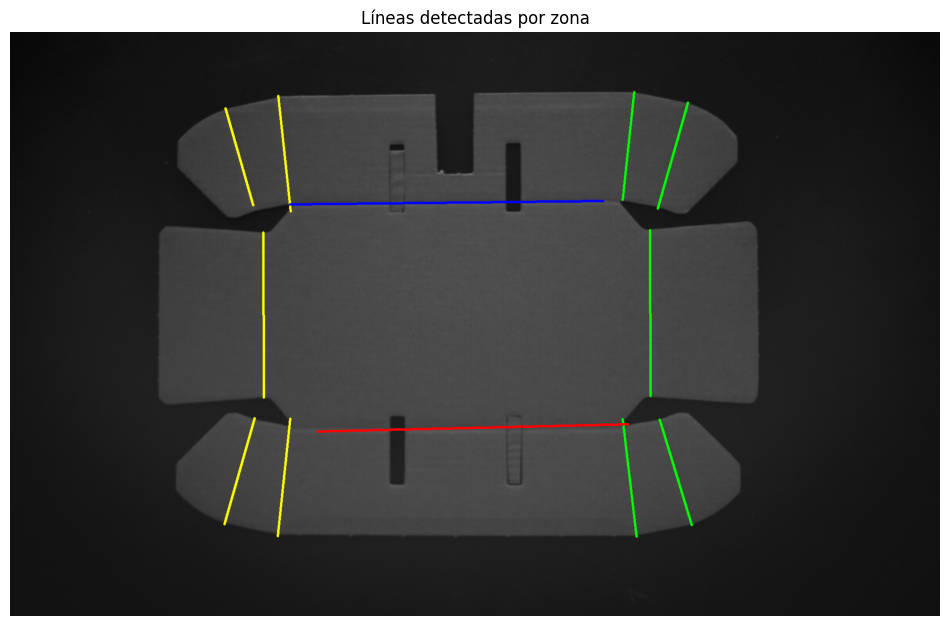

In [243]:
# Creamos una copia en color de la imagen base
output = cv.cvtColor(image_hor_up, cv.COLOR_GRAY2BGR)

# Dibujar líneas por grupo con diferentes colores
for x1, y1, x2, y2 in left_lines:
    cv.line(output, (x1, y1), (x2, y2), (0, 255, 255), 3)  # amarillo

for x1, y1, x2, y2 in right_lines:
    cv.line(output, (x1, y1), (x2, y2), (0, 255, 0), 3)  # verde

for x1, y1, x2, y2 in up_lines:
    cv.line(output, (x1, y1), (x2, y2), (255, 0, 0), 3)  # azul

for x1, y1, x2, y2 in down_lines:
    cv.line(output, (x1, y1), (x2, y2), (0, 0, 255), 3)  # rojo

# Mostrar la imagen resultante
plt.figure(figsize=(12, 8))
plt.title("Líneas detectadas por zona")
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()